# EV Population & Policy Analysis  
**TT10L Transportation Project**  
**Author:** Your Name  
**Date:** 2025-06-XX  
**Dataset:** Electric_Vehicle_Population_Data.csv  
**Objectives:**  
1. Q1: CAFV eligibility by vehicle type & range  
2. Q2: Range performance by make/model  
3. Q3: Yearly trends in range & price  
4. Q4: Geographic & utility drivers in WA state  


### Imports & Settings

In [62]:
# core
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modeling
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, r2_score

sns.set(style="whitegrid")

### Load & Inspect Data

In [63]:
df = pd.read_csv('Electric_Vehicle_Population_Data.csv')
print(df.shape)
df.head()

(186879, 17)


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,WBY8P6C58K,King,Seattle,WA,98115.0,2019,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,153,0,43.0,259254397,POINT (-122.3008235 47.6862671),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
1,5YJSA1DN4D,Kitsap,Bremerton,WA,98312.0,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,35.0,127420940,POINT (-122.6961203 47.5759584),PUGET SOUND ENERGY INC,5.303508e+10
2,5YJSA1E26J,King,Kent,WA,98042.0,2018,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,249,0,47.0,170287183,POINT (-122.1145138 47.3581107),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
3,WBY2Z2C54E,King,Bellevue,WA,98004.0,2014,BMW,I8,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14,0,41.0,205545868,POINT (-122.202397 47.619252),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
4,5YJXCDE23J,King,Bellevue,WA,98004.0,2018,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0,41.0,237977386,POINT (-122.202397 47.619252),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10


In [64]:
df.info()
df.describe(include='all').T
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186879 entries, 0 to 186878
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         186879 non-null  object 
 1   County                                             186876 non-null  object 
 2   City                                               186876 non-null  object 
 3   State                                              186879 non-null  object 
 4   Postal Code                                        186876 non-null  float64
 5   Model Year                                         186879 non-null  int64  
 6   Make                                               186879 non-null  object 
 7   Model                                              186879 non-null  object 
 8   Electric Vehicle Type                              186879 non-null  object

VIN (1-10)                                             0
County                                                 3
City                                                   3
State                                                  0
Postal Code                                            3
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 403
DOL Vehicle ID                                         0
Vehicle Location                                       8
Electric Utility                                       3
2020 Census Tract                                      3
dtype: int64

### Cleaning & Feature Engineering

1.Drop columns with too many missing values,

2.Fill small‐count missing in location fields,

3.Convert dtypes & rename CAFV column,

4.Create any derived metrics

In [65]:
# Drop high‐missing columns
df = df.drop(columns=['Legislative District'])  

# Fill missing in location/text fields
for col in ['County','City','Electric Utility','2020 Census Tract']:
    df[col] = df[col].fillna('Unknown')

# Postal Code: fill with mode
mode_pc = df['Postal Code'].mode()[0]
df['Postal Code'] = df['Postal Code'].fillna(mode_pc)

# Vehicle Location: fill with 'Unknown' or leave as-is if not critical
df['Vehicle Location'] = df['Vehicle Location'].fillna('Unknown')

# Convert numeric columns
df['Model Year']      = df['Model Year'].astype(int)
df['Electric Range']  = pd.to_numeric(df['Electric Range'], errors='coerce')
df['Base MSRP']       = pd.to_numeric(df['Base MSRP'], errors='coerce')

# Rename CAFV column for ease
df = df.rename(columns={
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility': 'CAFV_Eligibility'
})

# Example derived metric: range per year of service
df['Range_per_Year'] = df['Electric Range'] / (2025 - df['Model Year'] + 1)

# Verify
print(df.dtypes)
print(df.isna().sum().loc[['Electric Range','Base MSRP']])

VIN (1-10)                object
County                    object
City                      object
State                     object
Postal Code              float64
Model Year                 int32
Make                      object
Model                     object
Electric Vehicle Type     object
CAFV_Eligibility          object
Electric Range             int64
Base MSRP                  int64
DOL Vehicle ID             int64
Vehicle Location          object
Electric Utility          object
2020 Census Tract         object
Range_per_Year           float64
dtype: object
Electric Range    0
Base MSRP         0
dtype: int64


## Q1: CAFV Eligibility by EV Type  
**Objective**: Which EV types (BEV vs. PHEV) are most likely to receive CAFV status?  
**Fields**: `EV_Short`, `CAFV_Eligibility`, `Electric Range`, `Model Year`

### Crosstab & Stacked Bar

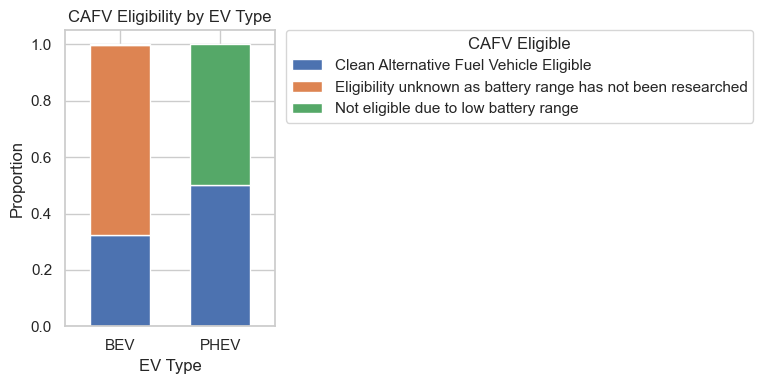

In [66]:
# 1. Load and preprocess
df = pd.read_csv('Electric_Vehicle_Population_Data.csv')
df = df.rename(columns={
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility': 'CAFV_Eligibility'
})
df['EV_Short'] = df['Electric Vehicle Type'].map({
    'Battery Electric Vehicle (BEV)': 'BEV',
    'Plug-in Hybrid Electric Vehicle (PHEV)': 'PHEV'
})

# 2. Crosstab
ct = pd.crosstab(
    df['EV_Short'],
    df['CAFV_Eligibility'],
    normalize='index'
)

# 3. Plot
fig, ax = plt.subplots(figsize=(8, 4))            
ct.plot(
    kind='bar',
    stacked=True,
    width=0.6,
    ax=ax
)

# 4. Labels & title
ax.set_ylabel('Proportion')
ax.set_xlabel('EV Type')
ax.set_title('CAFV Eligibility by EV Type')

# 5. Tweak x‐ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# 6. Legend outside
ax.legend(
    title='CAFV Eligible',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout()
plt.show()


Range Distribution Boxplot

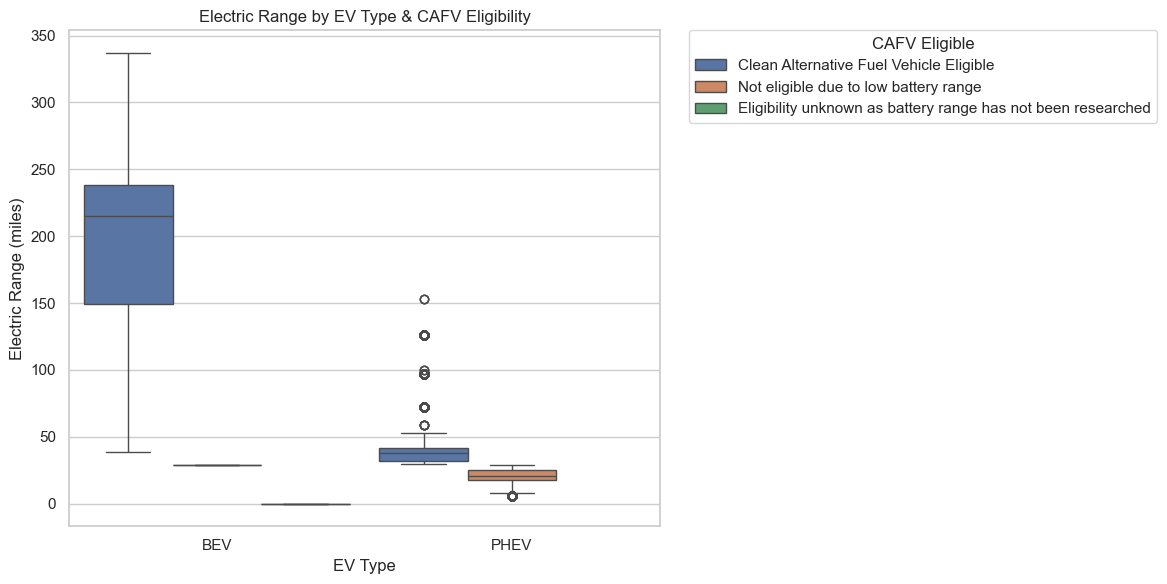

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure EV_Short exists
df['EV_Short'] = df['Electric Vehicle Type'].map({
    'Battery Electric Vehicle (BEV)': 'BEV',
    'Plug-in Hybrid Electric Vehicle (PHEV)': 'PHEV'
})

# Plot with wider boxes
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(
    data=df,
    x='EV_Short',
    y='Electric Range',
    hue='CAFV_Eligibility',
    width=0.9,
    ax=ax
)

ax.set_xlabel('EV Type')
ax.set_ylabel('Electric Range (miles)')
ax.set_title('Electric Range by EV Type & CAFV Eligibility')

ax.legend(
    title='CAFV Eligible',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout()
plt.show()

## Q2: Top EV Models by Average Range  
**Objective**: Which make/model combos deliver the highest electric range?  
**Fields**: `Make`, `Model`, `Electric Range`

In [68]:
top10 = (
    df.groupby(['Make','Model'])['Electric Range']
      .agg(['mean','count'])
      .query('count >= 5')
      .sort_values('mean', ascending=False)
      .head(10)
      .reset_index()
)
display(top10)


,Make,Model,mean,count
0,HYUNDAI,KONA,258.000000,224
1,TESLA,ROADSTER,234.583333,48
2,JAGUAR,I-PACE,203.741379,232
3,TESLA,MODEL S,174.770527,7831
4,CHEVROLET,BOLT EV,155.017857,7056
5,TESLA,MODEL X,132.596393,6043
6,AUDI,E-TRON,131.056744,1075
7,TESLA,MODEL 3,107.752100,30714
8,VOLKSWAGEN,E-GOLF,107.256267,1077
9,TOYOTA,RAV4,102.520000,50


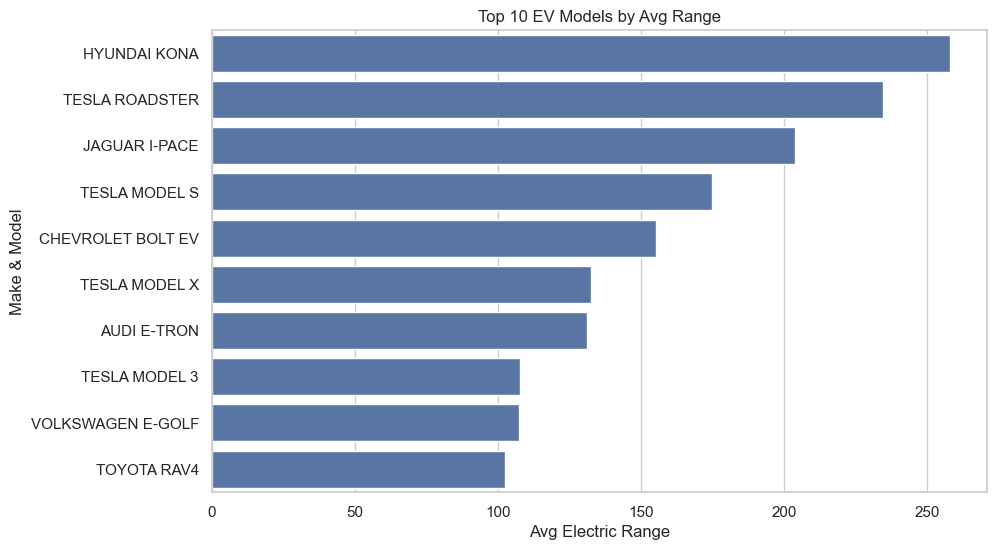

In [69]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='mean',
    y=top10['Make'] + ' ' + top10['Model'],
    data=top10
)
plt.xlabel('Avg Electric Range')
plt.ylabel('Make & Model')
plt.title('Top 10 EV Models by Avg Range')
plt.show()


## Q3: Yearly Trends in Range & MSRP  
**Objective**: Are newer models improving range and what’s the price trend?  
**Fields**: `Model Year`, `Electric Range`, `Base MSRP`

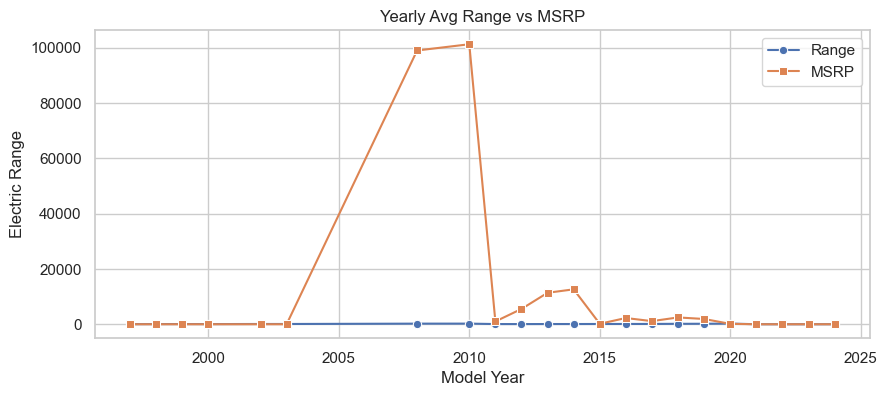

In [70]:
yearly = df.groupby('Model Year')[['Electric Range','Base MSRP']].mean().reset_index()

plt.figure(figsize=(10,4))
sns.lineplot(data=yearly, x='Model Year', y='Electric Range', marker='o', label='Range')
sns.lineplot(data=yearly, x='Model Year', y='Base MSRP',    marker='s', label='MSRP')
plt.title('Yearly Avg Range vs MSRP')
plt.legend()
plt.show()


## Q4: EV Distribution by County & Utility in Washington
**Objective**: Which WA counties and utilities host the most EVs?  
**Fields**: `State`, `County`, `Electric Utility`


In [71]:
# Clean the Base MSRP column: remove missing or zero values
df_price = df[(df['Base MSRP'].notna()) & (df['Base MSRP'] > 0)]

# Top 20 Counties by Average MSRP
avg_msrp_by_county = (
    df_price.groupby('County')['Base MSRP']
    .mean()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)
print("\nTop 20 Counties by Average MSRP:")
print(avg_msrp_by_county)


Top 20 Counties by Average MSRP:
          County      Base MSRP
0        Charles  102000.000000
1      Multnomah   90700.000000
2   Spotsylvania   75095.000000
3      Albemarle   69900.000000
4       Columbia   69900.000000
5      Riverside   69900.000000
6         Collin   69900.000000
7      Klickitat   65383.333333
8         Yakima   64279.117647
9        Cowlitz   62685.000000
10        Chelan   62595.625000
11      Franklin   60263.571429
12     Wahkiakum   59931.666667
13        Travis   59900.000000
14         Mason   59675.652174
15       Douglas   59471.363636
16         Grant   58650.000000
17         Clark   58197.443182
18          King   57937.282930
19        Skagit   57430.454545


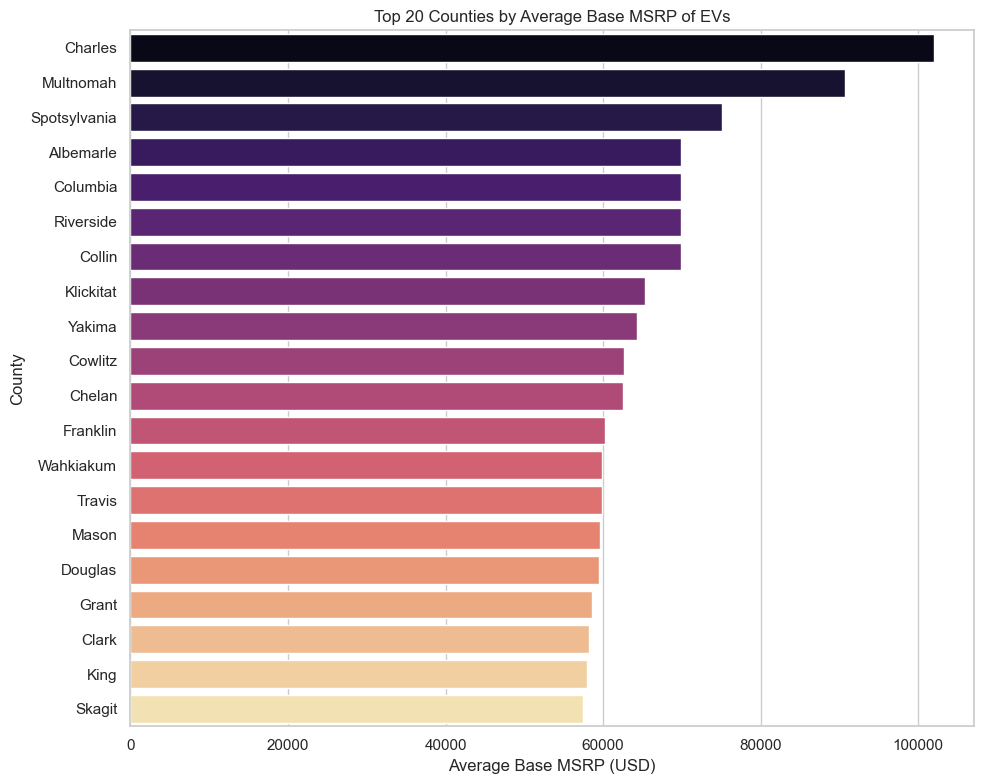

In [72]:
# Horizontal Bar Plot: Top 20 Counties by Average MSRP
plt.figure(figsize=(10, 8))
sns.barplot(
    data=avg_msrp_by_county,
    x='Base MSRP',
    y='County',
    hue='County',
    dodge=False,
    palette='magma',
    legend=False
)
plt.title('Top 20 Counties by Average Base MSRP of EVs')
plt.xlabel('Average Base MSRP (USD)')
plt.ylabel('County')
plt.tight_layout()

## Cell 5: Data Validation

In [73]:
# Check if 'Range_per_Year' already exists
if 'Range_per_Year' not in df.columns:
	df['Range_per_Year'] = df['Electric Range'] / (2025 - df['Model Year'] + 1)
 
# Verify it’s in DataFrame
print(df.columns.tolist())

['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'CAFV_Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract', 'EV_Short', 'Range_per_Year']


In [74]:
# Data Validation —
print(f"Rows: {df.shape[0]:,}    Columns: {df.shape[1]}")
print("\nColumn names:")
for col in df.columns:
    print(" •", col)

# Confirm have ≥1,000 rows and ≥10 attributes
assert df.shape[0] >= 1000, "Less than 1,000 rows!"
assert df.shape[1] >= 10,   "Less than 10 columns!"


Rows: 186,879    Columns: 19

Column names:
 • VIN (1-10)
 • County
 • City
 • State
 • Postal Code
 • Model Year
 • Make
 • Model
 • Electric Vehicle Type
 • CAFV_Eligibility
 • Electric Range
 • Base MSRP
 • Legislative District
 • DOL Vehicle ID
 • Vehicle Location
 • Electric Utility
 • 2020 Census Tract
 • EV_Short
 • Range_per_Year


In [75]:
# Numeric summary
display(df[['Electric Range','Base MSRP','Range_per_Year']].describe().T)

# Categorical summary
display(df[['EV_Short','Make','Model','County','Electric Utility','CAFV_Eligibility']].describe().T)

,count,mean,std,min,25%,50%,75%,max
Electric Range,186879.0,56.707790,90.788807,0.0,0.0,0.0,73.000000,337.000000
Base MSRP,186879.0,1011.918487,8115.767740,0.0,0.0,0.0,0.000000,845000.000000
Range_per_Year,186879.0,8.229660,13.240697,0.0,0.0,0.0,10.666667,56.166667


,count,unique,top,freq
EV_Short,186879,2,BEV,146297
Make,186879,40,TESLA,83349
Model,186879,143,MODEL Y,38648
County,186876,197,King,97012
Electric Utility,186876,76,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),69049
CAFV_Eligibility,186879,3,Eligibility unknown as battery range has not b...,98765


## Distributions & Correlations

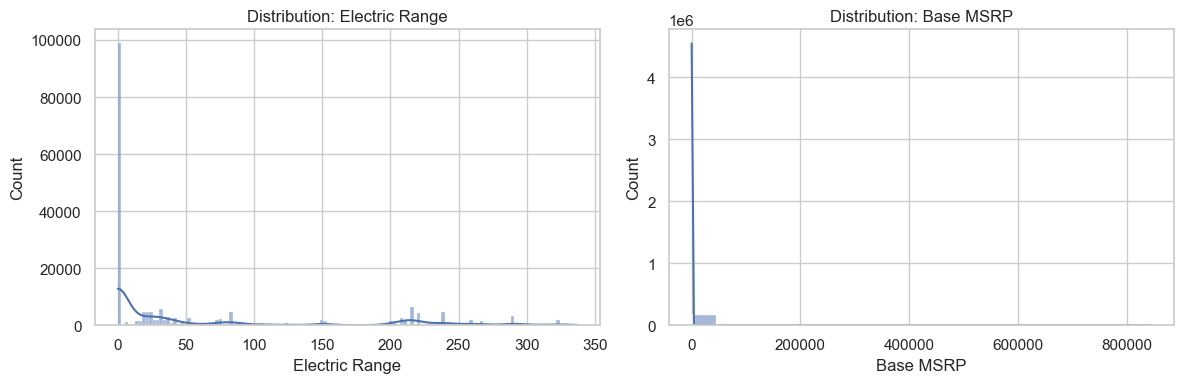

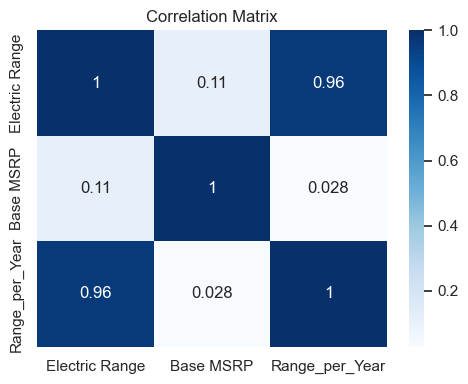

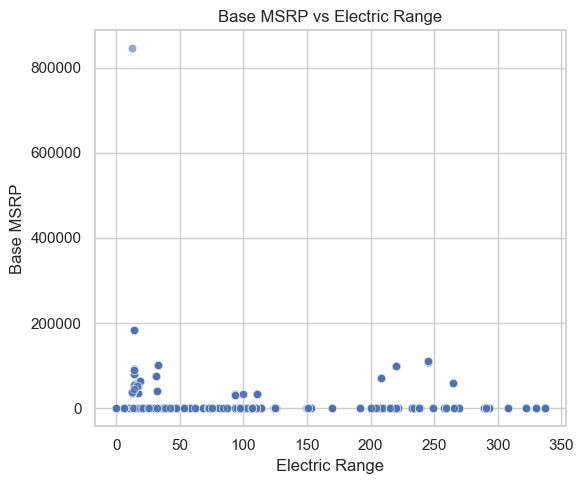

In [76]:
# — Distributions & Correlations —
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Histograms
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['Electric Range'].dropna(), kde=True, ax=axes[0])
axes[0].set_title('Distribution: Electric Range')
sns.histplot(df['Base MSRP'].dropna(),    kde=True, ax=axes[1])
axes[1].set_title('Distribution: Base MSRP')
plt.tight_layout()
plt.show()

# 2) Correlation matrix
corr = df[['Electric Range','Base MSRP','Range_per_Year']].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# 3) Scatterplot: Price vs Range
plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x='Electric Range', y='Base MSRP', alpha=0.6)
plt.title('Base MSRP vs Electric Range')
plt.tight_layout()
plt.show()

## Q1 Modeling & Evaluation (Logistic Regression)

In [77]:
# 1) Inspect target distribution
print(df['CAFV_Eligibility'].value_counts(dropna=False))

# 2) Keep only rows with clear eligible/ineligible status
eligible_val = 'Clean Alternative Fuel Vehicle Eligible'
not_eligible_val = 'Not eligible due to low battery range'
df_q1 = df[df['CAFV_Eligibility'].isin([eligible_val, not_eligible_val])].copy()
print(df_q1['CAFV_Eligibility'].value_counts())

# 3) Prepare features & target
X = pd.get_dummies(df_q1[['Electric Range','Model Year','EV_Short']], drop_first=True)
y = (df_q1['CAFV_Eligibility'] == eligible_val).astype(int)

# 4) Split with stratification
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5) Fit & evaluate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))


CAFV_Eligibility
Eligibility unknown as battery range has not been researched    98765
Clean Alternative Fuel Vehicle Eligible                         67807
Not eligible due to low battery range                           20307
Name: count, dtype: int64
CAFV_Eligibility
Clean Alternative Fuel Vehicle Eligible    67807
Not eligible due to low battery range      20307
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4061
           1       1.00      1.00      1.00     13562

    accuracy                           1.00     17623
   macro avg       1.00      1.00      1.00     17623
weighted avg       1.00      1.00      1.00     17623

ROC AUC: 0.9999999999999999


## Q3) Modeling & Evaluation (Linear Regression Forecast)

In [78]:
# 1) Aggregate yearly registration counts
reg_counts = (
    df['Model Year']
      .value_counts()
      .sort_index()
      .reset_index()
      .rename(columns={'index':'Year', 'Model Year':'count'})
)
# Ensure columns are named correctly
reg_counts.columns = ['Year', 'count']

# 2) Split
X = reg_counts[['Year']]
y = reg_counts['count']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Fit & evaluate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))

# 4) Forecast next year
next_year = pd.DataFrame({'Year':[reg_counts['Year'].max()+1]})
print("Forecast for", next_year.loc[0,'Year'], ":", lr.predict(next_year)[0])


MAE: 6843.74738428425
R² : -0.8138999276697747
Forecast for 2025 : 24359.137890204787


## Q4) Modeling & Evaluation (K-Means Clustering)

,County,EV_Count,Cluster
19,Grays Harbor,675,0
21,Franklin,617,0
22,Grant,615,0
23,Walla Walla,453,0
24,Douglas,378,0
25,Whitman,363,0
26,Klickitat,307,0
27,Okanogan,279,0
20,Kittitas,668,0
28,Stevens,235,0


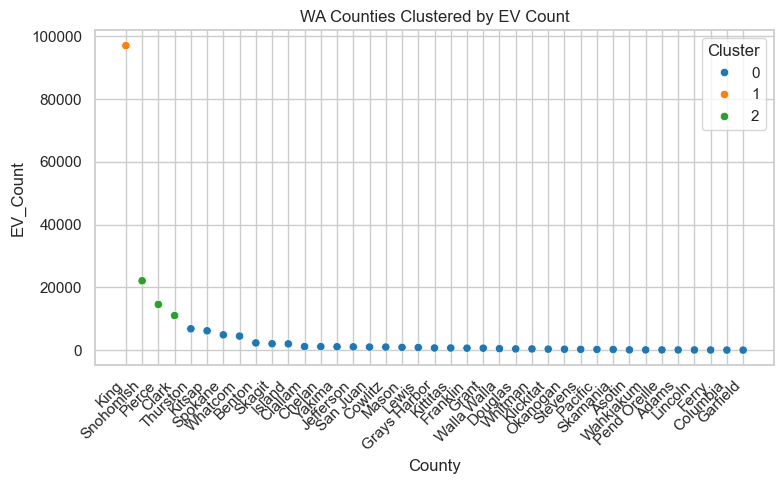

In [79]:
# 1) Prepare WA county EV counts
wa = df[df['State']=='WA']
by_county = (
    wa['County']
      .value_counts()
      .reset_index(name='EV_Count')
      .rename(columns={'index':'County'})
)

# 2) Fit KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
by_county['Cluster'] = kmeans.fit_predict(by_county[['EV_Count']])

# 3) Display cluster assignments
display(by_county.sort_values('Cluster'))

# 4) Plot clusters
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=by_county,
    x='County', y='EV_Count',
    hue='Cluster', palette='tab10'
)
plt.xticks(rotation=45, ha='right')
plt.title('WA Counties Clustered by EV Count')
plt.tight_layout()
plt.show()


## Model Performance Summary

| Question | Model                      | Key Metrics                                |
|----------|----------------------------|--------------------------------------------|
| Q1       | Logistic Regression        | *Precision*, *Recall*, *F1-score*, *ROC AUC* |
| Q2       | — (Descriptive only)       | —                                          |
| Q3       | Linear Regression Forecast | *MAE*, *R²*                                 |
| Q4′      | K-Means Clustering         | *# Clusters*, *Cluster Centers*            |


## Some Insights

**Q1 (CAFV Eligibility)**  
- BEVs vs. PHEVs: …  
- Model performance: …  

**Q2 (Top Models by Range)**  
- Top performers: …  
- Any caveats (low sample sizes): …

**Q3 (Trends & Forecast)**  
- Range ↑ by ~X mi/yr; price trend: …  
- Forecast next year: …  

**Q4′ (WA County & Utility Clusters)**  
- Cluster groups: …  
- Implications for charger deployment: …

**Limitations & Assumptions**
- E.g., ~30% “unknown” CAFV status  
- Linear vs. more advanced time-series methods  
- Clustering only on counts, not geography